# **Install Library**

In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requ

In [1]:
!pip install opendatasets
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 9.9 MB/s eta 0:00:00


In [2]:
!pip install tensorflow

In [3]:
# Import important library

import re
import nltk
import string
import numpy as np
import pandas as pd
import contractions
import tensorflow as tf
import opendatasets as od
import matplotlib.pyplot as plt

import gensim
from gensim.models import Word2Vec

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# **Menyiapkan Data**

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text")

print("Path to dataset files:", path)

100%|██████████| 814k/814k [00:00<00:00, 911kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text/versions/1


In [7]:
# Deklarasi data

df = pd.read_csv(path+'/data.csv',encoding='latin1')
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [8]:
df = df[['Tweet', 'HS']]
df.head()

,Tweet,HS
0,- disaat semua cowok berusaha melacak perhatia...,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1


In [9]:
# mendapatkan informasi dari tipe dan keterangn data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   13169 non-null  object
 1   HS      13169 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 205.9+ KB


# **Pre Prossesing**

In [10]:
# Cek duplikasi data

df.duplicated().sum()

138

In [11]:
# Menghapus dat ayang duplikat

df = df.drop_duplicates()
df.duplicated().sum()

0

In [12]:
# Cek apakah ada data yang null

df.isnull().sum()

,0
Tweet,0
HS,0


In [13]:
# Cek string yang salah

problematic_strings = []
for index, text in df['Tweet'].items():
    try:
        _ = contractions.fix(text)
    except IndexError:
        problematic_strings.append((index, text))
        print(f"Error at index {index}: '{text}'")

In [14]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import contractions
import re
import string

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = stopwords.words('indonesian')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
stop_words.append('yg')

In [17]:
alay_dict = pd.read_csv(path+'/new_kamusalay.csv', encoding='latin-1', header=None)

In [29]:
from google.colab import files
files.download(path+"/new_kamusalay.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
alay_dict_map = dict(zip(alay_dict[0], alay_dict[1]))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

In [19]:
def remove_repeated_words(text):
    # Hapus pengulangan kata
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text, flags=re.IGNORECASE)

    # Hapus pengulangan karakter terlalu banyak: "xfxfxfxf" -> "xf"
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    return text

In [20]:
# Melakukan prosessing

stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = normalize_alay(text)
    text = contractions.fix(text)
    text = re.sub('[^a-zA-Z\s]', ' ', text)

    text = remove_repeated_words(text)

    text = "".join([word for word in text if word not in string.punctuation])
    text = " ".join([stemmer.stem(word) for word in text.split()])

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if not word.startswith('x')]
    tokens = [word for word in tokens if len(word) > 1]
    tokens = [word for word in tokens if word not in stop_words]

    return " ".join(tokens)

df['Tweet'] = df['Tweet'].apply(preprocess)

df.head(6)

,Tweet,HS
0,cowok berusaha melacak perhatian gue lanta rem...,1
1,rt user pengguna telat tau elu edan sarap gue ...,0
2,kadang berfikir percaya tuhan padah jatuh berk...,0
3,pengguna nku tau matamu sipit,0
4,pengguna kaum cebong kafir dongoknya dungu hah...,1
5,pengguna ya bani taplak kawan,1


In [21]:
# Mendeklarasikan data x dan y yang akan digunakan pada pelatihan

X=df["Tweet"]
y=df["HS"]

# **Traning Word2vec**

In [22]:
# Memecah setiap kalimat dalam X menjadi list kata
sentences = [sentence.split() for sentence in X]

# Melatih model Word2Vec menggunakan skip-gram (sg=1)
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=50,
    window=2,
    sg=1,
    min_count=1,
    workers=4,
    seed=42
)

# Spliting Data

In [23]:
# Membagi data menjadi train dan test dengan porsi 80 20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Training Model**

In [24]:
# Inisialisasi tokenizer dan latih pada data teks X_train
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Mengubah teks menjadi urutan indeks kata
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Menentukan ukuran kata unik + 1
vocab_size = len(tokenizer.word_index) + 1

In [26]:
# Save
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
w2v_model.save('w2v.model')

In [ ]:
# Membuat EarlyStopping untuk memberhentikan proses traing jika val_loss terus naik sebanyak 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

In [ ]:
max_length = 50

# Padding setiap urutan kata di akhir (post-padding) agar panjangnya sama (50)
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

X_train[0]

array([   1, 5841,  784,   91,   86,    2, 3630,   78, 8832,  137, 8833,
       3025, 8834, 3631, 3632,   24,   50, 5842,  103,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
# Inisialisasi matriks embedding dengan nol, ukuran: (jumlah kata, dimensi vektor)
embedding_matrix = np.zeros(((vocab_size, 50)))

# Mengisi matriks embedding dengan vektor Word2Vec untuk kata-kata yang ditemukan
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [ ]:
# Inisialisasi model Sequential
model = Sequential()

# Layer embedding menggunakan matriks Word2Vec
model.add(Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=max_length, trainable=False))

# Layer Bi-LSTM untuk menangkap konteks dari dua arah
model.add(Bidirectional(LSTM(64)))

# Fully connected layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# # Hidden layer tambahan
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))

# # Hidden layer tambahan
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.4))

# Output layer untuk 4 kelas
model.add(Dense(1, activation='sigmoid'))

# Kompilasi model dengan loss categorical crossentropy dan optimizer Adam
model.compile(loss='binary_crossentropy',optimizer=Adam(0.00001),metrics=['accuracy'])
# model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

# Membangun model dengan input shape tertentu agar summary bisa ditampilkan
model.build(input_shape=(None, max_length))

# Menampilkan arsitektur model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 50, 50)         │       970,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 128)            │        58,880 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,033,541 (3.94 MB)

 Trainable params: 63,041 (246.25 KB)

 Non-trainable params: 970,500 (3.70 MB)

In [ ]:
num_epochs = 400

# Melatih model dengan data training dan validasi
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), batch_size=64,callbacks=[early_stopping])

Epoch 1/400
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5258 - loss: 0.6923 - val_accuracy: 0.5723 - val_loss: 0.6884
Epoch 2/400
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5885 - loss: 0.6856 - val_accuracy: 0.5696 - val_loss: 0.6840
Epoch 3/400
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5877 - loss: 0.6812 - val_accuracy: 0.5692 - val_loss: 0.6810
Epoch 4/400
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5850 - loss: 0.6787 - val_accuracy: 0.5696 - val_loss: 0.6780
Epoch 5/400
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5825 - loss: 0.6757 - val_accuracy: 0.5708 - val_loss: 0.6744
Epoch 6/400
163/163 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5909 - loss: 0.6726 - val_accuracy: 0.5719 - val_loss: 0.6699
Epoch 7/400
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5963 - loss: 0.6653 - val_accuracy: 0.5827 - val_loss: 0.6641
Epoch 8/400
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6158 - loss: 0.6592 - 

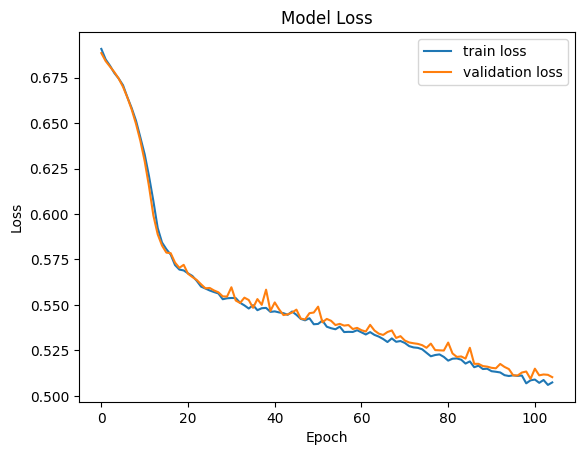

In [ ]:
# Menampilkan grafik loss selama training

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

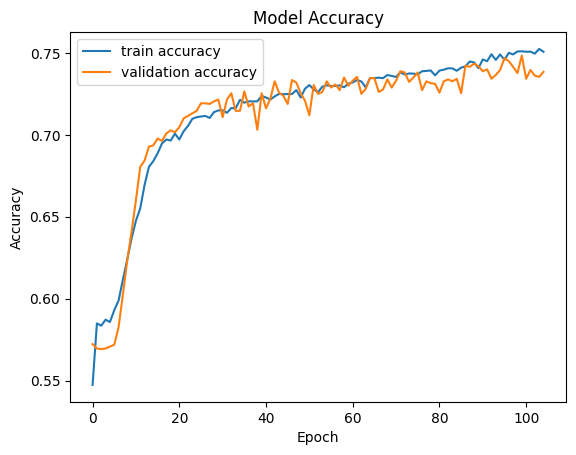

In [ ]:
# Menampilkan grafik akurasi selama training

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Melakukan prediksi pada data
result = model.predict(X_test)
y_pred = (result > 0.5).astype("int32")

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
# Cek akurasi secara manual

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.7483697736862294
Precision: 0.7439546289573578
Recall: 0.7402753147774421
F1 score: 0.741697488312746


In [ ]:
model.save('nlp.keras')
model.save('nlp.h5')